In [169]:
from ShapeFunctions import *
from GaussQuadrature import *
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize

### REFERENCE ELEMENT
ElType = 0
ElOrder = 1
n = 3
dim = 2
XeREF = np.array([[1,0], [0,0], [0,1]])
TeREF = np.array([0, 1, 2])
XeintREF = np.array([[0,0.5],[0.5,0]])
#XeintREF = np.array([[0.5,0.5],[0.5,0]])
XeintREF = np.array([[0.5,0.5],[0.3,0]])


QuadratureOrder = 3
#### QUADRATURE TO INTEGRATE SURFACES (2D)
z, w, Ng2D = GaussQuadrature(ElType,QuadratureOrder)
N, dNdxi, dNdeta = EvaluateShapeFunctions(ElType, ElOrder, n, z)


In [170]:
# TESSELLATION OF REFERENCE ELEMENT

def CheckNodeOnEdge(x,Xe,TOL):
    """ Function which checks if point with coordinates x is on any edge of the element with nodal coordinates Xe. """
    n = np.shape(Xe)[0]
    edgecheck = False
    for edge in range(n):
        i = edge
        j = (edge+1)%n
        if Xe[j,0] == Xe[i,0]:
            if abs(Xe[i,0]-x[0]) < TOL:
                edgecheck = True
                break
        else:
            y = lambda x : ((Xe[j,1]-Xe[i,1])*x+Xe[i,1]*Xe[j,0]-Xe[j,1]*Xe[i,0])/(Xe[j,0]-Xe[i,0])  # function representing the restriction on the edge
            if abs(y(x[0])-x[1]) < TOL:
                edgecheck = True
                break
    if edgecheck == True:
        return i, j
    else:
        return "Point not on edges"
        
CheckNodeOnEdge(XeintREF[0,:],XeREF,1e-1)

def Tessellation(Xe,Xeint):
    """ This function performs the TESSELLATION of an element with nodal coordinates Xe and interface coordinates Xeint (intersection with edges) 
    Input: - Xe: element nodal coordinates 
            - Xeint: coordinates of intersection points between interface and edges 
    Output: - XeTESS: Nodal coordinates matrix storing the coordinates of the element vertex and interface points 
            - TeTESS: Tessellation connectivity matrix such that 
                      TeTESS = [[Connectivities for subelement 1]
                                [Connectivities for subelement 2]
                                            ...                            
            """
            
    # FIRST WE NEED TO DETERMINE WHICH IS THE VERTEX COMMON TO BOTH EDGES INTERSECTING WITH THE INTERFACE
    # AND ORGANISE THE NODAL MATRIX ACCORDINGLY SO THAT
    #       - THE FIRST ROW CORRESPONDS TO THE VERTEX COORDINATES WHICH IS SHARED BY BOTH EDGES INTERSECTING THE INTERFACE 
    #       - THE SECOND ROW CORRESPONDS TO THE VERTEX COORDINATES WHICH DEFINES THE EDGE ON WHICH THE FIRST INTERSECTION POINT IS LOCATED
    #       - THE THIRD ROW CORRESPONDS TO THE VERTEX COORDINATES WHICH DEFINES THE EDGE ON WHICH THE SECOND INTERSECTION POINT IS LOCATED
    
    n = np.shape(Xe)[0]
    Nint = np.shape(Xeint)[0]  # number of intersection points
    edgenodes = np.zeros(np.shape(Xeint), dtype=int)
    nodeedgeinter = np.zeros([Nint], dtype=int)
    for i in range(Nint):
        edgenodes[i,:] = CheckNodeOnEdge(Xeint[i,:],Xe,1e-3)
    commonnode = (set(edgenodes[0,:])&set(edgenodes[1,:])).pop()
    for i in range(Nint):
        edgenodesset = set(edgenodes[i,:])
        edgenodesset.remove(commonnode)
        nodeedgeinter[i] = edgenodesset.pop()
    
    Xe = Xe[np.concatenate((np.array([commonnode]), nodeedgeinter), axis=0),:]

    # MODIFIED NODAL MATRIX AND CONECTIVITIES, ACCOUNTING FOR 3 SUBTRIANGLES 
    XeTESS = np.concatenate((Xe, Xeint), axis=0)
    TeTESS = np.zeros([3, n], dtype = int)  # connectivities for 3 subtriangles

    TeTESS[0,:] = [0, 3, 4]  # first triangular subdomain is common node and intersection nodes

    # COMPARE DISTANCE INTERFACE-(EDGE NODE)
    edge = 1
    distance1 = np.linalg.norm(Xeint[edge-1,:]-Xe[edge,:])
    edge = 2
    distance2 = np.linalg.norm(Xeint[edge-1,:]-Xe[edge,:])

    if distance1 <= distance2:
        TeTESS[1,:] = [3, 1, 2]
        TeTESS[2,:] = [3, 4, 2]
    if distance1 > distance2:
        TeTESS[1,:] = [4, 2, 1]
        TeTESS[2,:] = [4, 3, 1]
    
    return XeTESS, TeTESS


# COMPUTE MODIFIED QUADRATURE BY MAPPING 2D QUADRATURE TO REFERENCE SUBELEMENTS
# 2. DO TESSELLATION ON REFERENCE ELEMENT
XeREF = np.array([[1,0], [0,1], [0,0]])
XemodREF, TemodREF = Tessellation(XeREF,XeintREF)
Nsub = np.shape(TemodREF)[0]

print("XemodREF", XemodREF)

print("TemodREF", TemodREF)

XemodREF [[1.  0. ]
 [0.  1. ]
 [0.  0. ]
 [0.5 0.5]
 [0.3 0. ]]
TemodREF [[0 3 4]
 [4 2 1]
 [4 3 1]]


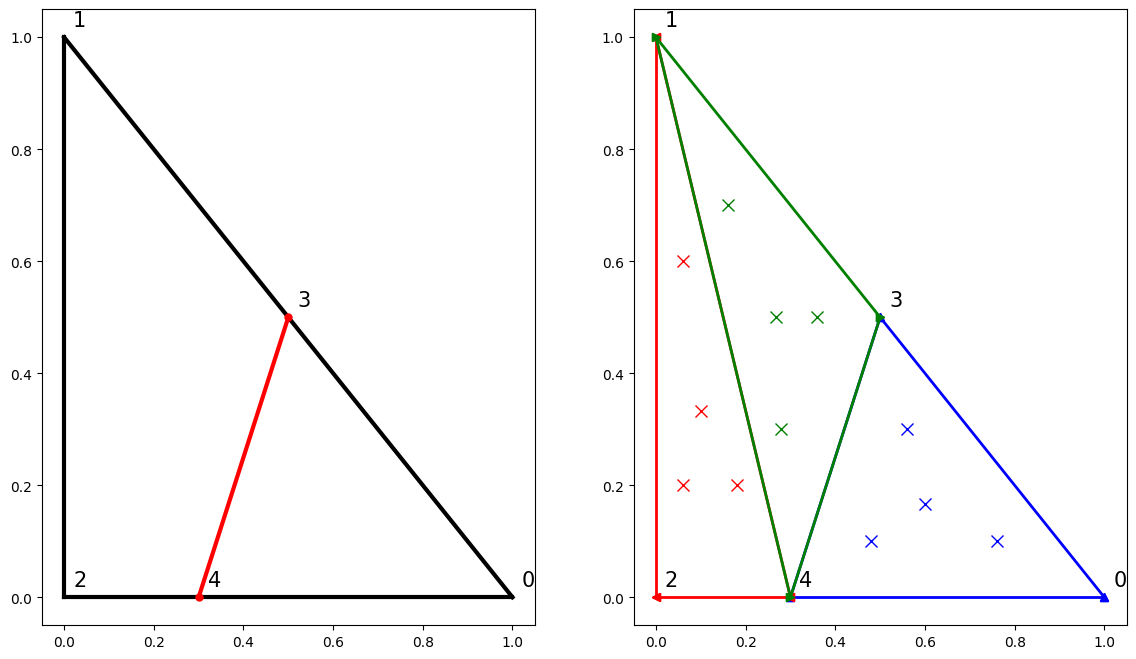

In [171]:
# 3. MAP 2D REFERENCE GAUSS INTEGRATION NODES ON THE REFERENCE SUBELEMENTS 
XgmodREF = np.zeros([Nsub*Ng2D,dim])
for i in range(Nsub):
    for ig in range(Ng2D):
        XgmodREF[Ng2D*i+ig,:] = N[ig,:] @ XemodREF[TemodREF[i,:]]
        
#### PLOT
fig, axs = plt.subplots(1, 2, figsize=(14,8))

## PLOT 2D REFERENCE ELEMENT
for i in range(n):
    axs[0].plot([XeREF[int(TeREF[i])-1,0], XeREF[int(TeREF[int((i+1)%n)])-1,0]], 
            [XeREF[int(TeREF[i])-1,1], XeREF[int(TeREF[int((i+1)%n)])-1,1]], color='black', linewidth=3)
# PLOT INTERFACE LINEAR APPROXIMATION
axs[0].plot(XeintREF[:,0], XeintREF[:,1], '.', color='red',markersize=10)
axs[0].plot(XeintREF[:,0], XeintREF[:,1],color='red', linewidth=3)
# PLOT NODE NUMERATION
d = 0.02
for i in range(len(XemodREF[:,0])):
    axs[0].text(XemodREF[i,0]+d,XemodREF[i,1]+d,str(i),fontsize=15)

# PLOT TESSELLATION ON REFERENCE ELEMENT
colorlist = ['blue', 'red', 'green']
markerlist = ['^', '<', '>']
for i in range(Nsub):
    for j in range(n):   # plot edges
        axs[1].plot([XemodREF[TemodREF[i,j],0], XemodREF[TemodREF[i,int((j+1)%n)],0]], [XemodREF[TemodREF[i,j],1], XemodREF[TemodREF[i,int((j+1)%n)],1]],
                color = colorlist[i], linewidth=2 , marker=markerlist[i])
    axs[1].plot(XgmodREF[Ng2D*i:Ng2D*(i+1),0],XgmodREF[Ng2D*i:Ng2D*(i+1),1],'x',color=colorlist[i], markersize = 8)
# PLOT NODE NUMERATION
d = 0.02
for i in range(len(XemodREF[:,0])):
    axs[1].text(XemodREF[i,0]+d,XemodREF[i,1]+d,str(i),fontsize=15)


In [172]:
# COMPUTE AREA OF TRIANGLES:

def Area(Xe):
    edge1 = np.linalg.norm(Xe[0,:]-Xe[1,:])
    edge2 = np.linalg.norm(Xe[1,:]-Xe[2,:])
    edge3 = np.linalg.norm(Xe[2,:]-Xe[0,:])
    s = (edge1 + edge2 + edge3)/2
    area = (s*(s-edge1)*(s-edge2)*(s-edge3)) ** 0.5
    return area

area1 = Area(XemodREF[TemodREF[0,:]])
area2 = Area(XemodREF[TemodREF[1,:]])
area3 = Area(XemodREF[TemodREF[2,:]])

print(area1)
print(area2)
print(area3)
print(area1+area2+area3)

0.17500000000000004
0.14999999999999988
0.1749999999999999
0.4999999999999999


In [173]:
# COMPUTE INTEGRAL USING MODIFIED QUADRATURE
def fun(z):
    return 1

####### SUMMARY
### 2D REFERENCE ELEMENT:
#   XeREF: NODAL COORDINATES OF 2D REFERENCE ELEMENT
#   TeREF: CONNECTIVITY MATRIX OF 2D REFERENCE ELEMENT
#   XeintREF: NODAL COORDINATES OF INTERFACE IN 2D REFERENCE ELEMENT
### 2D REFERENCE ELEMENT WITH TESSELLATION:
#   XemodREF: NODAL COORDINATES OF 2D REFERENCE ELEMENT WITH TESSELLATION
#   TemodREF: CONNECTIVITY MATRIX OF 2D REFERENCE ELEMENT WITH TESSELLATION
#   XgmodREF: GAUSS NODAL COORDINATES IN 2D REFERENCE ELEMENT WITH TESSELLATION, MODIFIED QUADRATURE

# EVALUATE 2D REFERENCE SHAPE FUNCTIONS ON MODIFIED GAUSS NODES
Nmod, dNdximod, dNdetamod = EvaluateShapeFunctions(ElType, ElOrder, n, XgmodREF)

integral = np.zeros([Nsub])
# INTEGRATE IDENTITY FUNCTION
for subelem in range(Nsub):
    for ig in range(Ng2D):
        # COMPUTE JACOBIAN OF TOTAL TRANSFORMATION
        invJ, detJ = Jacobian(XemodREF[TemodREF[subelem,:],0],XemodREF[TemodREF[subelem,:],1],dNdximod[Nsub*subelem+ig,:],dNdetamod[Nsub*subelem+ig,:])
        # COMPUTE INTEGRAL
        integral[subelem] += fun(XgmodREF[Nsub*subelem+ig,:]) * np.abs(detJ) * w[ig]

print(integral)
print(np.sum(integral))

[0.175 0.15  0.175]
0.4999999999999999


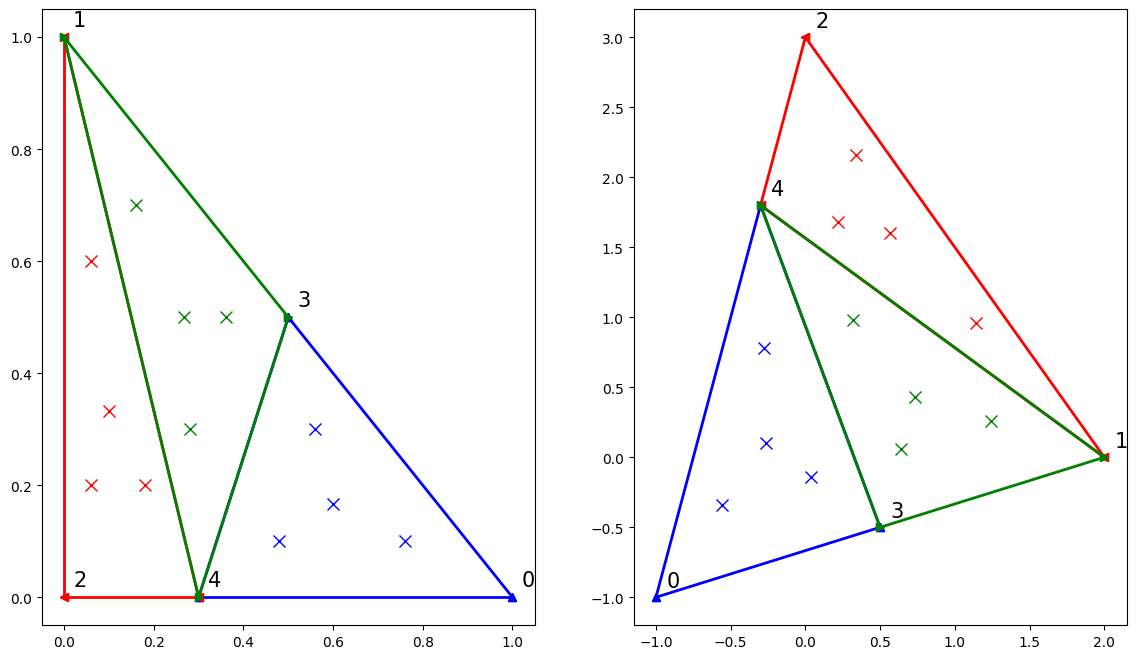

In [185]:
# GENERATE RANDOM ELEMENT ON PHYSICAL SPACE:

# DEFINE RANDOM ELEMENT
Xe = np.array([[-1, -1],[2,0],[0,3]])
#Xe = np.array([[-2, -0.5],[4,1],[0,3]])
#Xe = np.array([[0,0],[2,0],[0,2]])
Te = np.array([0,1,2])

# MAPP INTERFACE TO PHYSICAL ELEMENT
Xeint = np.zeros([len(XeintREF[:,0]),2])
Nint, foo, foo = EvaluateShapeFunctions(ElType, ElOrder, n, XeintREF)
for ig in range(len(XeintREF[:,0])):
    Xeint[ig,:] = Nint[ig,:] @ Xe
    
Xemod, Temod = Tessellation(Xe,Xeint)
    
# MAPP MODIFIED GAUSS POINTS TO PHYSICAL ELEMENT
Xgmod = np.zeros([Ng2D*Nsub,2])
for ig in range(Ng2D*Nsub):
    Xgmod[ig,:] = Nmod[ig,:] @ Xe

#### PLOT
fig, axs = plt.subplots(1, 2, figsize=(14,8))

# PLOT TESSELLATION ON REFERENCE ELEMENT
colorlist = ['blue', 'red', 'green']
markerlist = ['^', '<', '>']
for i in range(Nsub):
    for j in range(n):   # plot edges
        axs[0].plot([XemodREF[TemodREF[i,j],0], XemodREF[TemodREF[i,int((j+1)%n)],0]], [XemodREF[TemodREF[i,j],1], XemodREF[TemodREF[i,int((j+1)%n)],1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])
    axs[0].plot(XgmodREF[Ng2D*i:Ng2D*(i+1),0],XgmodREF[Ng2D*i:Ng2D*(i+1),1],'x',color=colorlist[i], markersize = 8)
# PLOT NODE NUMERATION
d = 0.02
for i in range(len(XemodREF[:,0])):
    axs[0].text(XemodREF[i,0]+d,XemodREF[i,1]+d,str(i),fontsize=15)
    
# PLOT TESSELLATION ON PHYSICAL ELEMENT
colorlist = ['blue', 'red', 'green']
markerlist = ['^', '<', '>']
for i in range(Nsub):
    for j in range(n):   # plot edges
        axs[1].plot([Xemod[Temod[i,j],0], Xemod[Temod[i,int((j+1)%n)],0]], [Xemod[Temod[i,j],1], Xemod[Temod[i,int((j+1)%n)],1]],
                 linestyle = '-', color = colorlist[i], linewidth=2 , marker=markerlist[i])
    axs[1].plot(Xgmod[Ng2D*i:Ng2D*(i+1),0],Xgmod[Ng2D*i:Ng2D*(i+1),1],'x',color=colorlist[i], markersize = 8)
# PLOT NODE NUMERATION
d = 0.07
for i in range(len(Xemod[:,0])):
    axs[1].text(Xemod[i,0]+d,Xemod[i,1]+d,str(i),fontsize=15)


In [181]:

area1 = Area(Xemod[Temod[0,:]])
area2 = Area(Xemod[Temod[1,:]])
area3 = Area(Xemod[Temod[2,:]])

print(area1)
print(area2)
print(area3)
print(area1+area2+area3)


0.6999999999999997
0.6
0.7000000000000003
2.0


In [182]:

####### SUMMARY
### 2D REFERENCE ELEMENT:
#   XeREF: NODAL COORDINATES OF 2D REFERENCE ELEMENT
#   TeREF: CONNECTIVITY MATRIX OF 2D REFERENCE ELEMENT
#   XeintREF: NODAL COORDINATES OF INTERFACE IN 2D REFERENCE ELEMENT
### 2D REFERENCE ELEMENT WITH TESSELLATION:
#   XemodREF: NODAL COORDINATES OF 2D REFERENCE ELEMENT WITH TESSELLATION
#   TemodREF: CONNECTIVITY MATRIX OF 2D REFERENCE ELEMENT WITH TESSELLATION
#   XgmodREF: GAUSS NODAL COORDINATES IN 2D REFERENCE ELEMENT WITH TESSELLATION, MODIFIED QUADRATURE
### 2D REFERENCE ELEMENT WITH TESSELLATION:
#   Xemod: NODAL COORDINATES OF 2D PHYSICAL ELEMENT WITH TESSELLATION
#   Temod: CONNECTIVITY MATRIX OF 2D PHYSICAL ELEMENT WITH TESSELLATION
#   Xgmod: GAUSS NODAL COORDINATES IN 2D PHYSICAL ELEMENT WITH TESSELLATION, MODIFIED QUADRATURE

# Nmod, dNdximod, dNdetamod: 2D REFERENCE SHAPE FUNCTIONS EVALUATED AT MODIFIED REFERENCE GAUSS INTEGRATION NODES

integral = np.zeros([Nsub])
# INTEGRATE IDENTITY FUNCTION
for subelem in range(Nsub):
    for ig in range(Ng2D):
        # COMPUTE JACOBIAN OF TOTAL TRANSFORMATION
        invJ, detJ = Jacobian(Xemod[Temod[subelem,:],0],Xemod[Temod[subelem,:],1],dNdximod[Nsub*subelem+ig,:],dNdetamod[Nsub*subelem+ig,:])
        # COMPUTE INTEGRAL
        integral[subelem] += fun(Xgmod[Nsub*subelem+ig,:]) * np.abs(detJ) * w[ig]

print(integral)
print(np.sum(integral))

[0.7 0.6 0.7]
2.0
